In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [170]:
def load_dataset(limit: int = 10**7, columns: list[str] = []):
    weather = pd.read_csv('./weather.csv', index_col=0).dropna()[:limit]
    weather.index = pd.to_datetime(weather.index)
    if len(columns) != 0:
        weather = weather[columns]

    mean = weather['temperature'].mean()
    std = weather['temperature'].std()

    high_thresh = mean+std*2.5
    low_thresh = mean-std*3

    weather['temperature'] = weather['temperature'].apply(lambda x: high_thresh if x > high_thresh else x)
    weather['temperature'] = weather['temperature'].apply(lambda x: low_thresh if x < low_thresh else x)
    
    return weather

weather = load_dataset()
weather.head()

,temperature,relative_humidity,dewpoint,apparent_temperature,surface_pressure,windspeed
time,,,,,,
2000-01-01 00:00:00,-5.8,87.0,-7.6,-10.8,999.4,12.8
2000-01-01 01:00:00,-6.1,88.0,-7.7,-10.9,999.8,11.8
2000-01-01 02:00:00,-6.4,89.0,-7.9,-11.1,1000.1,10.9
2000-01-01 03:00:00,-7.1,89.0,-8.6,-11.8,1000.3,10.3
2000-01-01 04:00:00,-7.6,90.0,-9.0,-12.3,1000.3,10.0


In [171]:
weather.corr()

,temperature,relative_humidity,dewpoint,apparent_temperature,surface_pressure,windspeed
temperature,1.000000,-0.443882,0.951339,0.995584,-0.135475,-0.121940
relative_humidity,-0.443882,1.000000,-0.151510,-0.407322,-0.166468,-0.027394
dewpoint,0.951339,-0.151510,1.000000,0.959196,-0.202373,-0.139473
apparent_temperature,0.995584,-0.407322,0.959196,1.000000,-0.117097,-0.195844
surface_pressure,-0.135475,-0.166468,-0.202373,-0.117097,1.000000,-0.302737
windspeed,-0.121940,-0.027394,-0.139473,-0.195844,-0.302737,1.000000


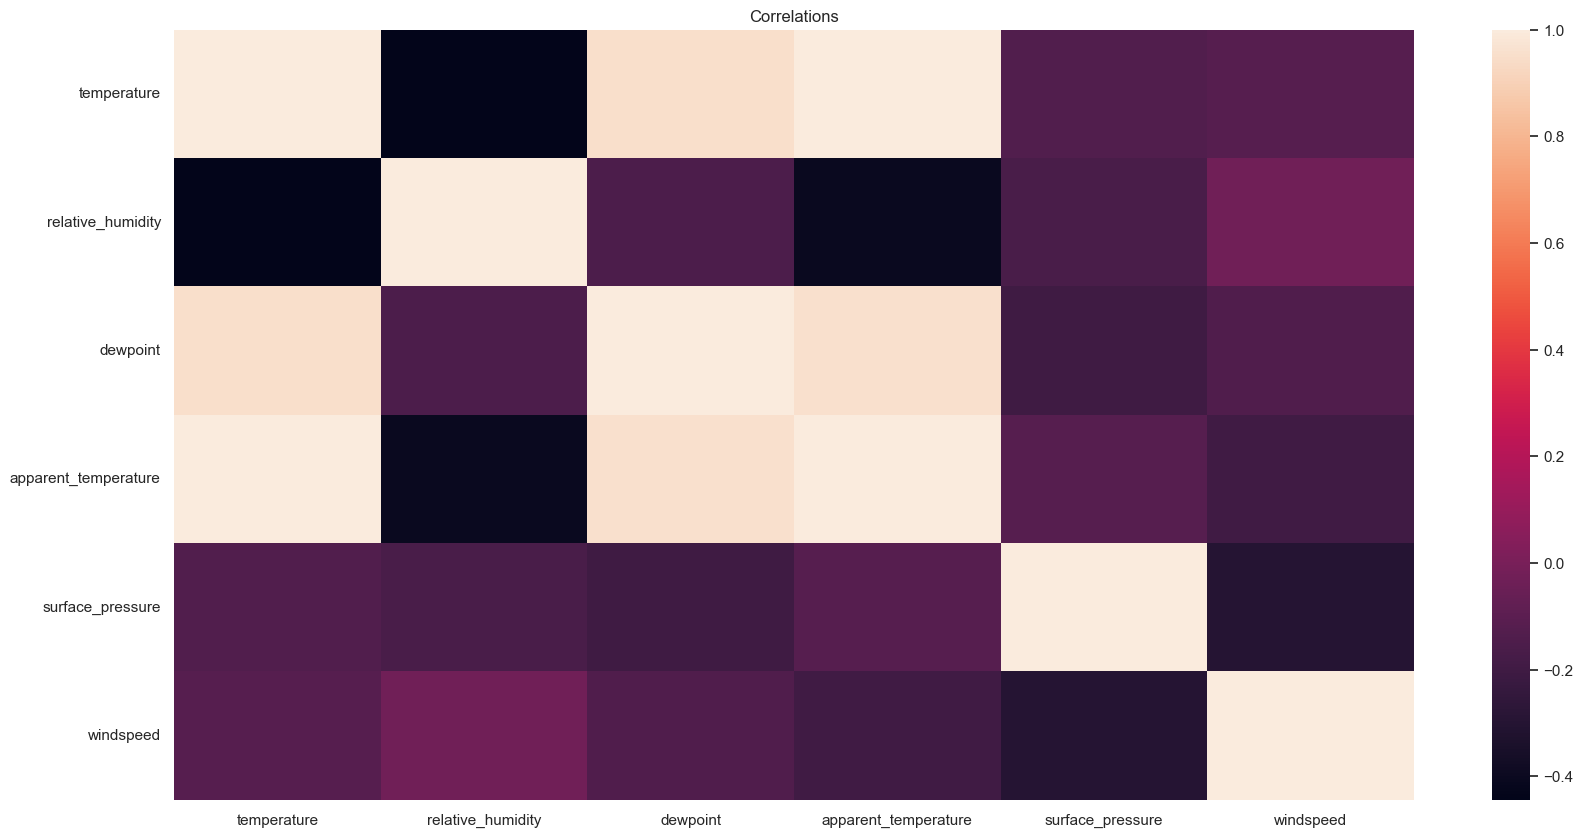

In [172]:
sns.heatmap(weather.corr())
plt.title('Correlations')
plt.show()

In [173]:
weather = weather.drop(['dewpoint', 'apparent_temperature'], axis=1)
weather.head()

,temperature,relative_humidity,surface_pressure,windspeed
time,,,,
2000-01-01 00:00:00,-5.8,87.0,999.4,12.8
2000-01-01 01:00:00,-6.1,88.0,999.8,11.8
2000-01-01 02:00:00,-6.4,89.0,1000.1,10.9
2000-01-01 03:00:00,-7.1,89.0,1000.3,10.3
2000-01-01 04:00:00,-7.6,90.0,1000.3,10.0


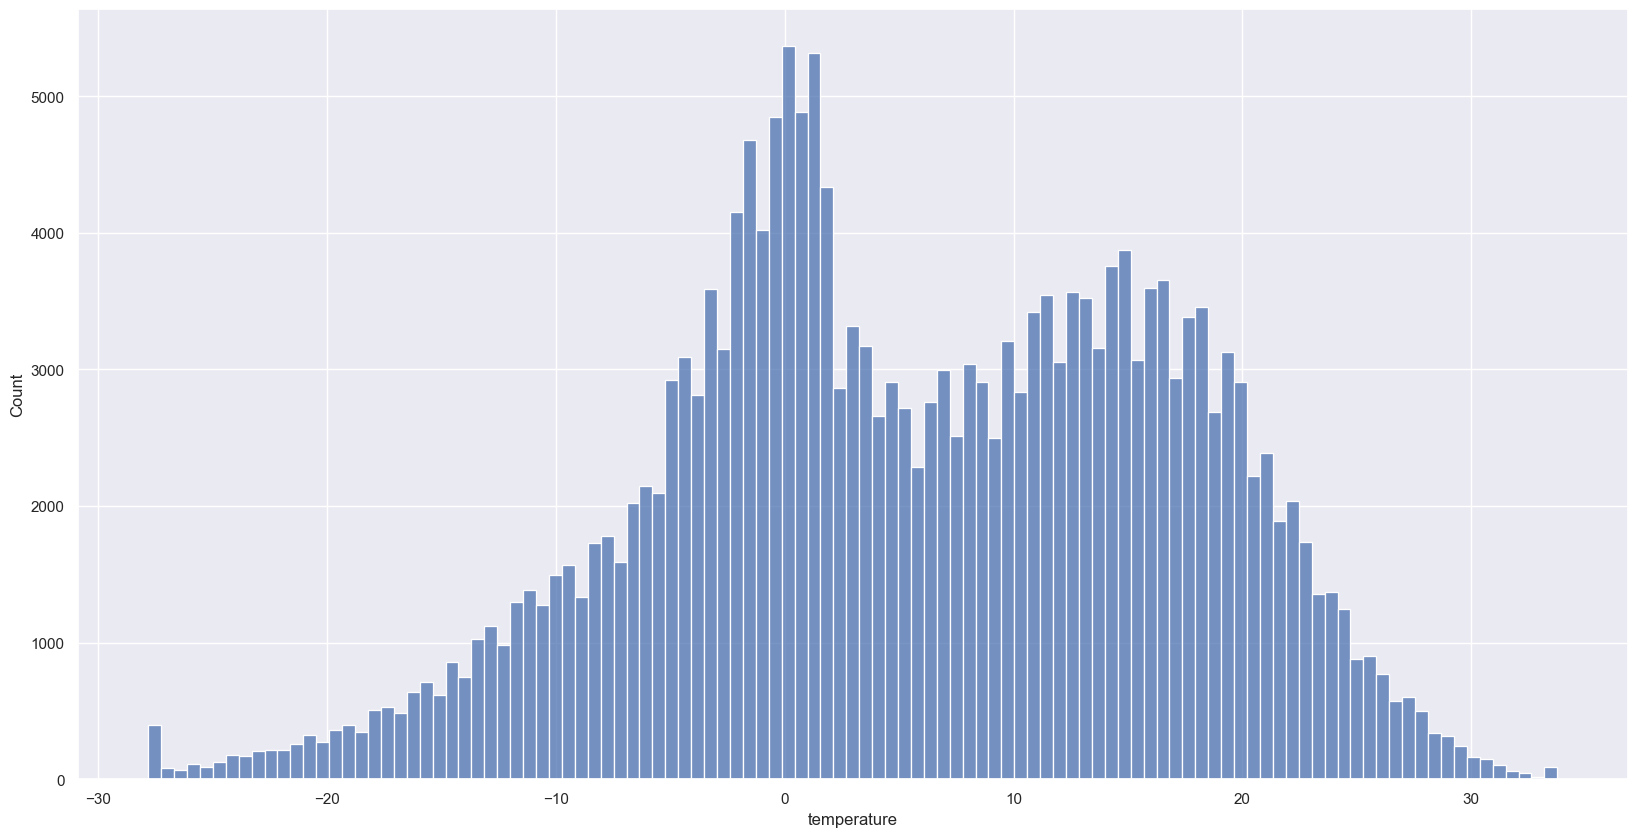

In [174]:
sns.histplot(weather['temperature'])
plt.show()

[]

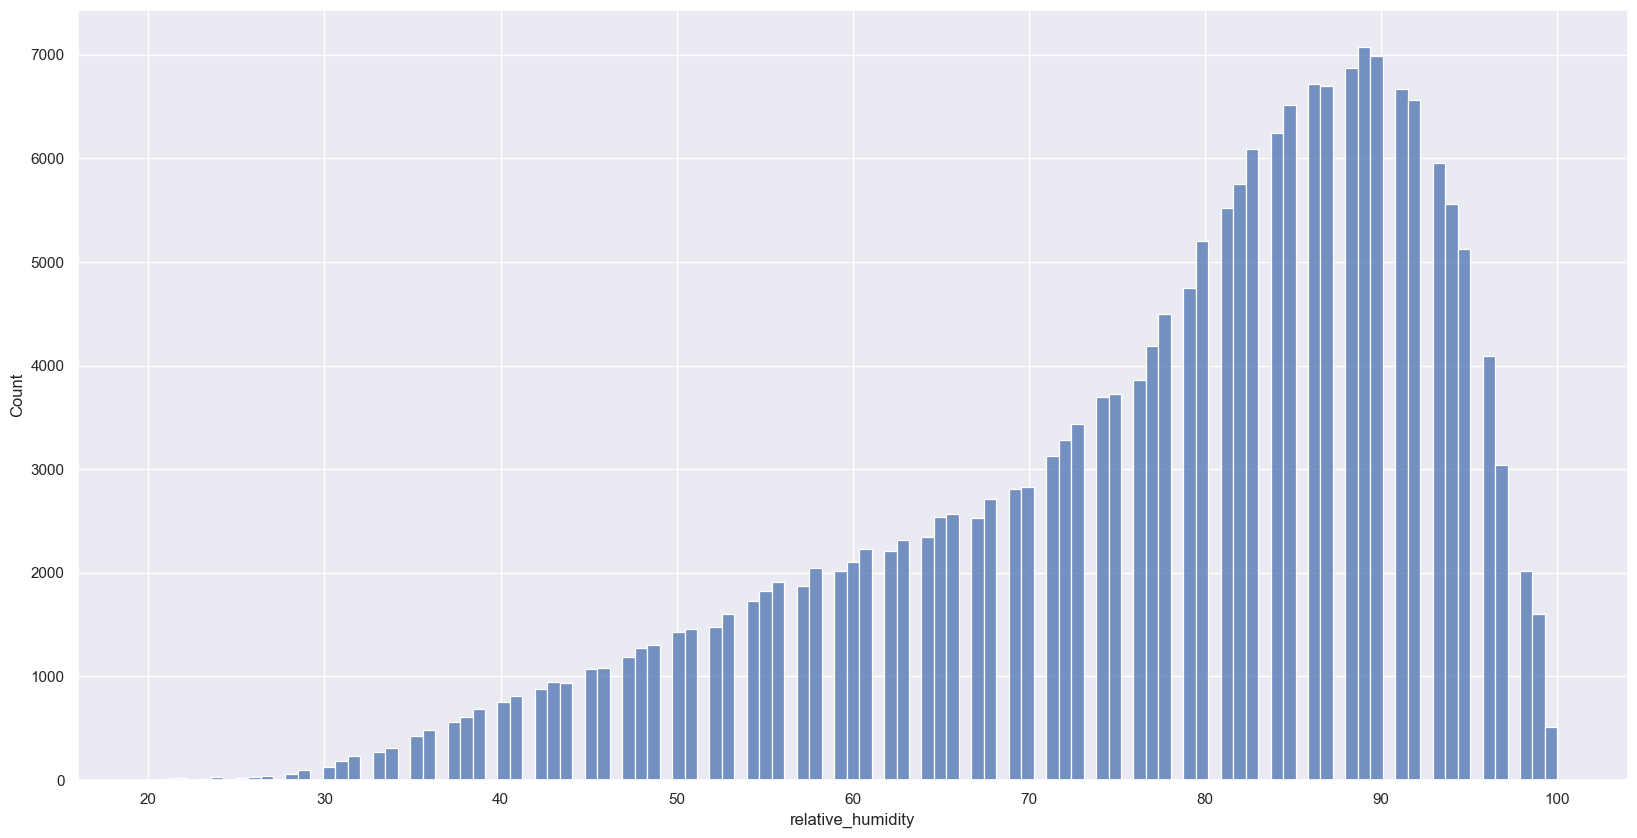

In [175]:
sns.histplot(weather['relative_humidity'])
plt.plot()

In [52]:
def get_train_test(weather, window_size: int = 168, predict_duration: int = 24, shuffle: bool = True):
    feature_matrix = pd.concat([weather[column].shift(i) for i in range(1, window_size+1) for column in weather.columns], axis=1)
    feature_matrix.columns = [f'{column}(n-{i})' for i in range(1, window_size+1) for column in weather.columns]

    feature_matrix['temperature(n)'] = weather['temperature']
    for i in range(1, predict_duration):
        feature_matrix[f'temperature(n+{i})'] = weather['temperature'].shift(-i)


    feature_matrix = feature_matrix.dropna()
    next_cols = ['temperature(n)']
    next_cols.extend([f'temperature(n+{i})' for i in range(1, predict_duration)])
    
    X_train, X_test, y_train, y_test = train_test_split(
        feature_matrix.drop(next_cols, axis=1),
        feature_matrix[next_cols],
        test_size=0.2,
        shuffle=shuffle,
        random_state=42,
    )

    return X_train, X_test, y_train, y_test

In [53]:
def score(model, X_test, y_test):
    pred = model.predict(X_test)

    print('MSE:', mean_squared_error(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))
    print('R2:', r2_score(y_test, pred))

In [54]:
def draw(model, title: str, test_amount: int = 7, window_size: int = 168, columns: list[str] = ['temperature'], predict_duration: int = 24):
    weather = load_dataset(columns=columns)
    _, X_test, _, y_test = get_train_test(weather, window_size, predict_duration, shuffle=False)
    
    y_pred = model.predict(X_test)[::predict_duration]
    y_test = y_test[::predict_duration]
    y_test_pred = y_pred[:test_amount].reshape(1, -1)[0]
    y_test_actual = y_test.values[:test_amount].reshape(1, -1)[0]

    # Plot the predicted vs. actual temperatures
    sns.set(rc={'figure.figsize': (20, 10)})
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_test_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time (hours)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

### Linear Regression

In [191]:
weather = load_dataset()
X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
score(linear_model, X_test, y_test)

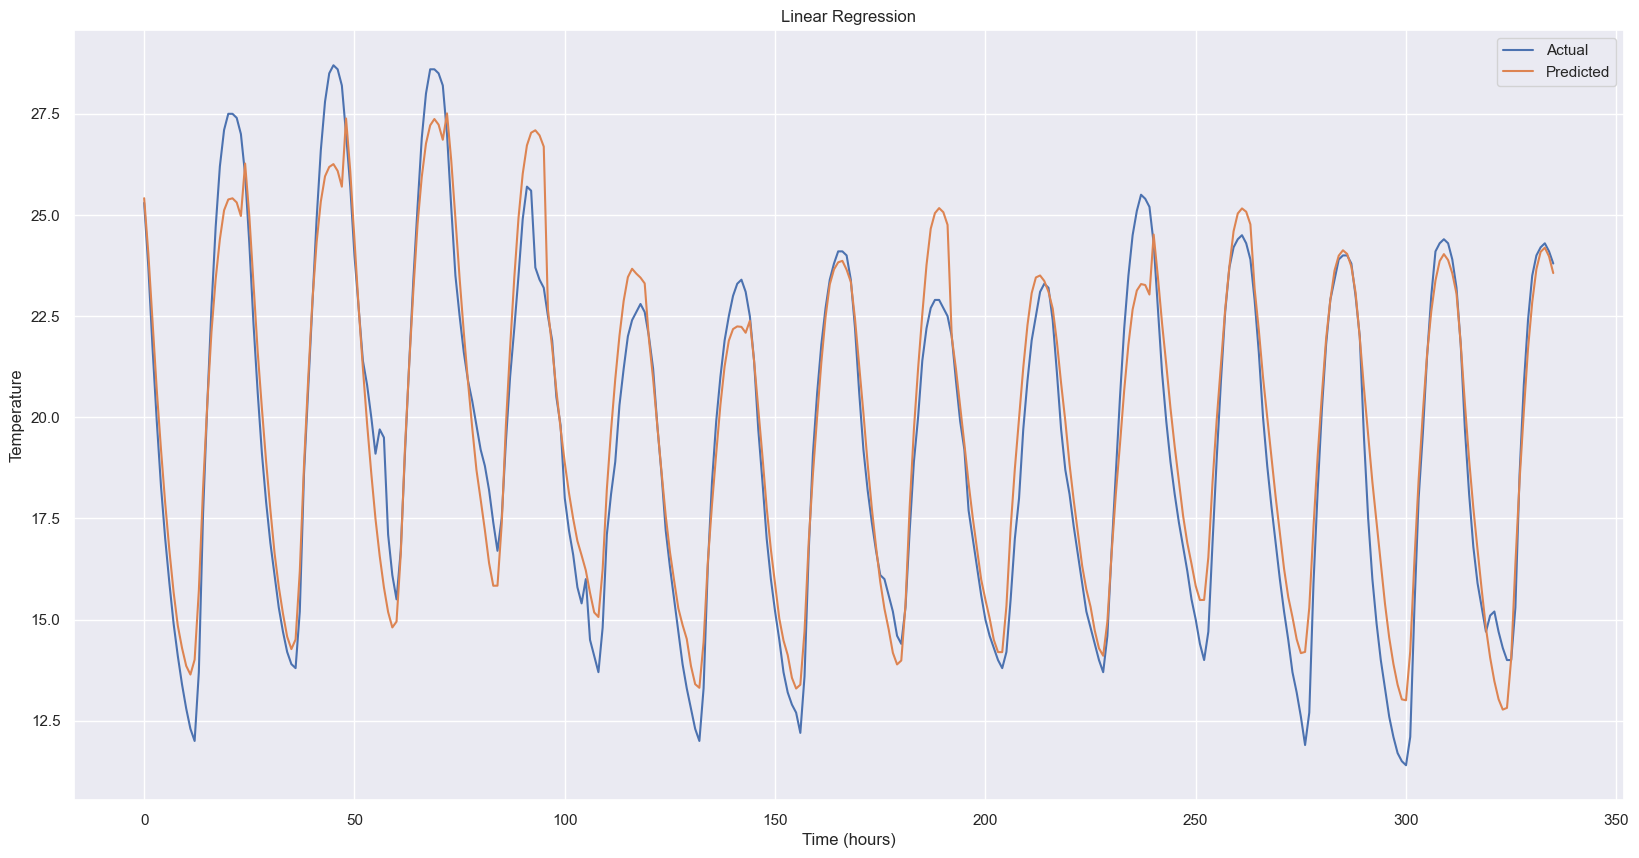

In [193]:
draw(linear_model, 'Linear Regression', test_amount=14, columns=weather.columns)

### find optimal window_size

In [39]:
results = []
window_sizes = [
    24, # 1 day
    48, # 2 days
    72, # 3 days
    168, # 1 week 
    336, # 2 weeks
    672, # 4 weeks
]

weather = load_dataset()
for size in window_sizes:
    X_train, X_test, y_train, y_test = get_train_test(weather, size, 24)
    
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    pred = linear_model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    results.append({
        'window_size': size,
        'mse': mse,
        'mae': mae,
    })

results

[{'window_size': 24, 'mse': 5.581076090365343, 'mae': 1.6678029142072142},
 {'window_size': 48, 'mse': 5.31962901419982, 'mae': 1.6286981126125897},
 {'window_size': 72, 'mse': 5.185106591775338, 'mae': 1.6093258024385513},
 {'window_size': 168, 'mse': 5.028869794184105, 'mae': 1.5917076255781761},
 {'window_size': 336, 'mse': 5.021391304465978, 'mae': 1.591001353065799},
 {'window_size': 672, 'mse': 5.0820557408079585, 'mae': 1.603928702539305}]

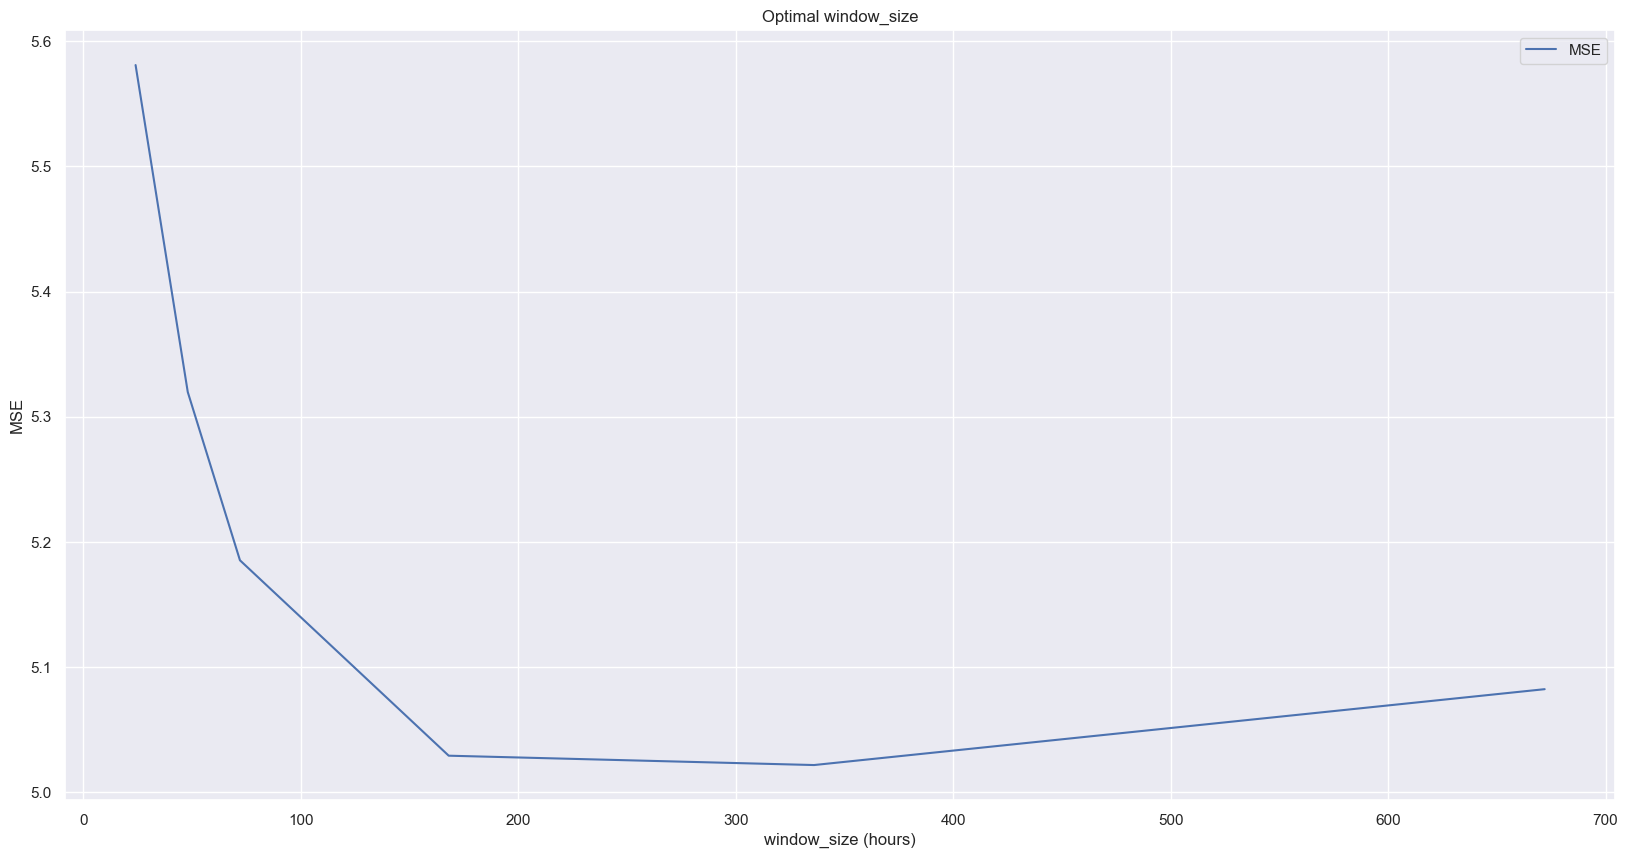

In [46]:
results_df = pd.DataFrame(results)
sns.set(rc={'figure.figsize': (20, 10)})
plt.plot(results_df['window_size'], results_df['mse'])
plt.title('Optimal window_size')
plt.xlabel('window_size (hours)')
plt.ylabel('MSE')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


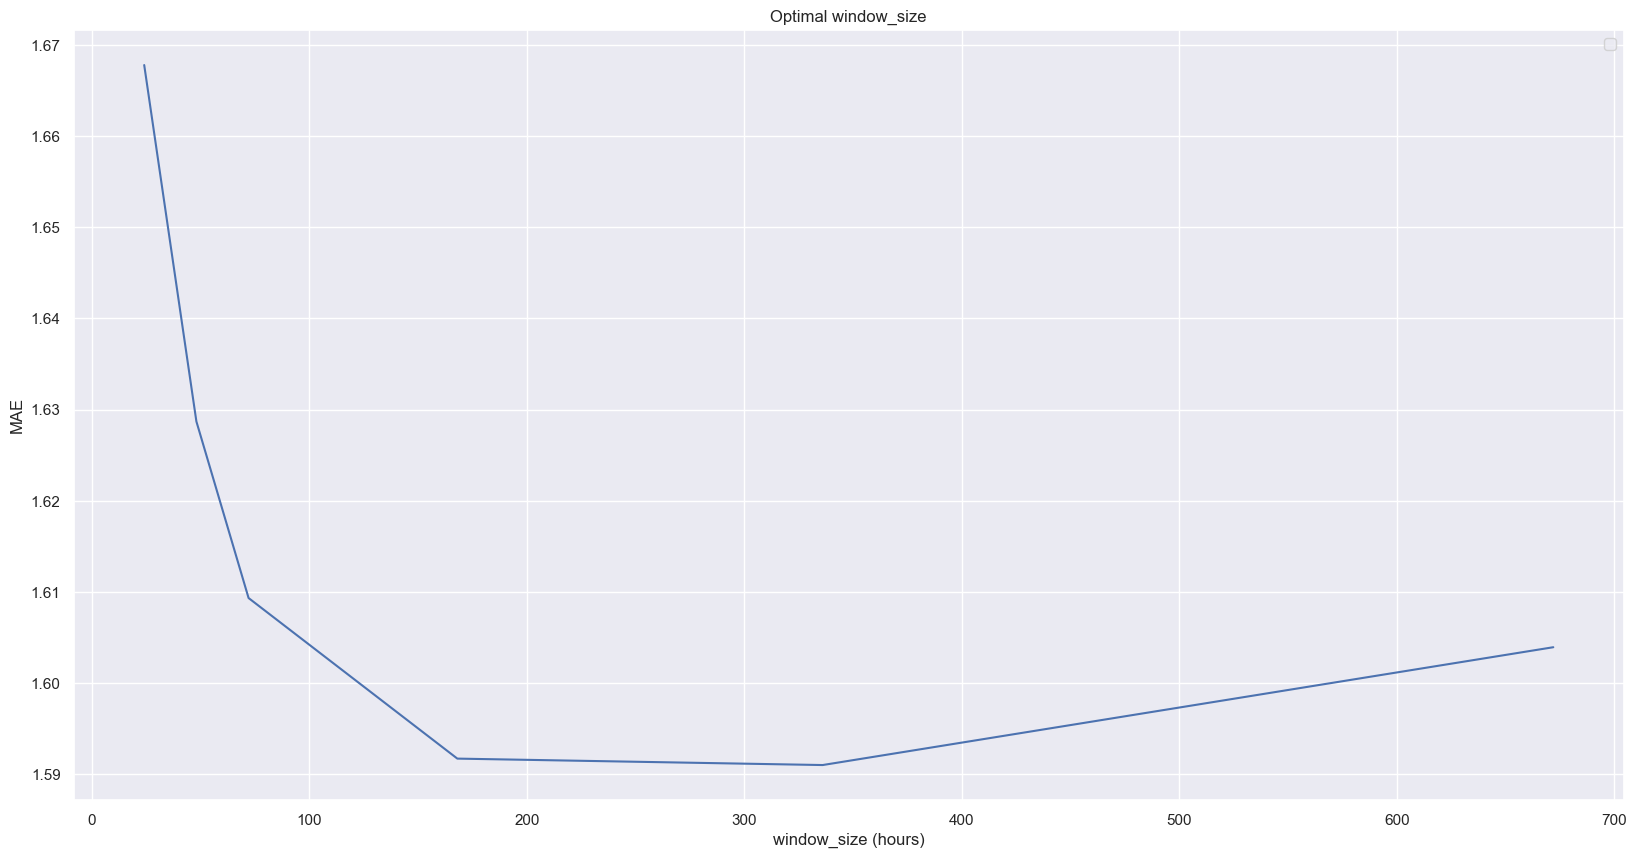

In [44]:
plt.plot(results_df['window_size'], results_df['mae'])
plt.title('Optimal window_size')
plt.xlabel('window_size (hours)')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
plt.plot(results_df['window_size'], results_df['r2'], label='MSE')
plt.title('Optimal window_size')
plt.xlabel('window_size (hours)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [55]:
pickle.dump(linear_model, open('./models/linear', 'wb'))

In [56]:
linear2 = pickle.load(open('./models/linear', 'rb'))
score(linear2, X_test, y_test)

MSE: 5.028869794184105
MAE: 1.5917076255781761
R2: 0.9598047774440865


### Random Forest

In [177]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)

random_forest_model = RandomForestRegressor(n_estimators=100, criterion='squared_error')
random_forest_model.fit(X_train, y_train)
score(random_forest_model, X_test, y_test)

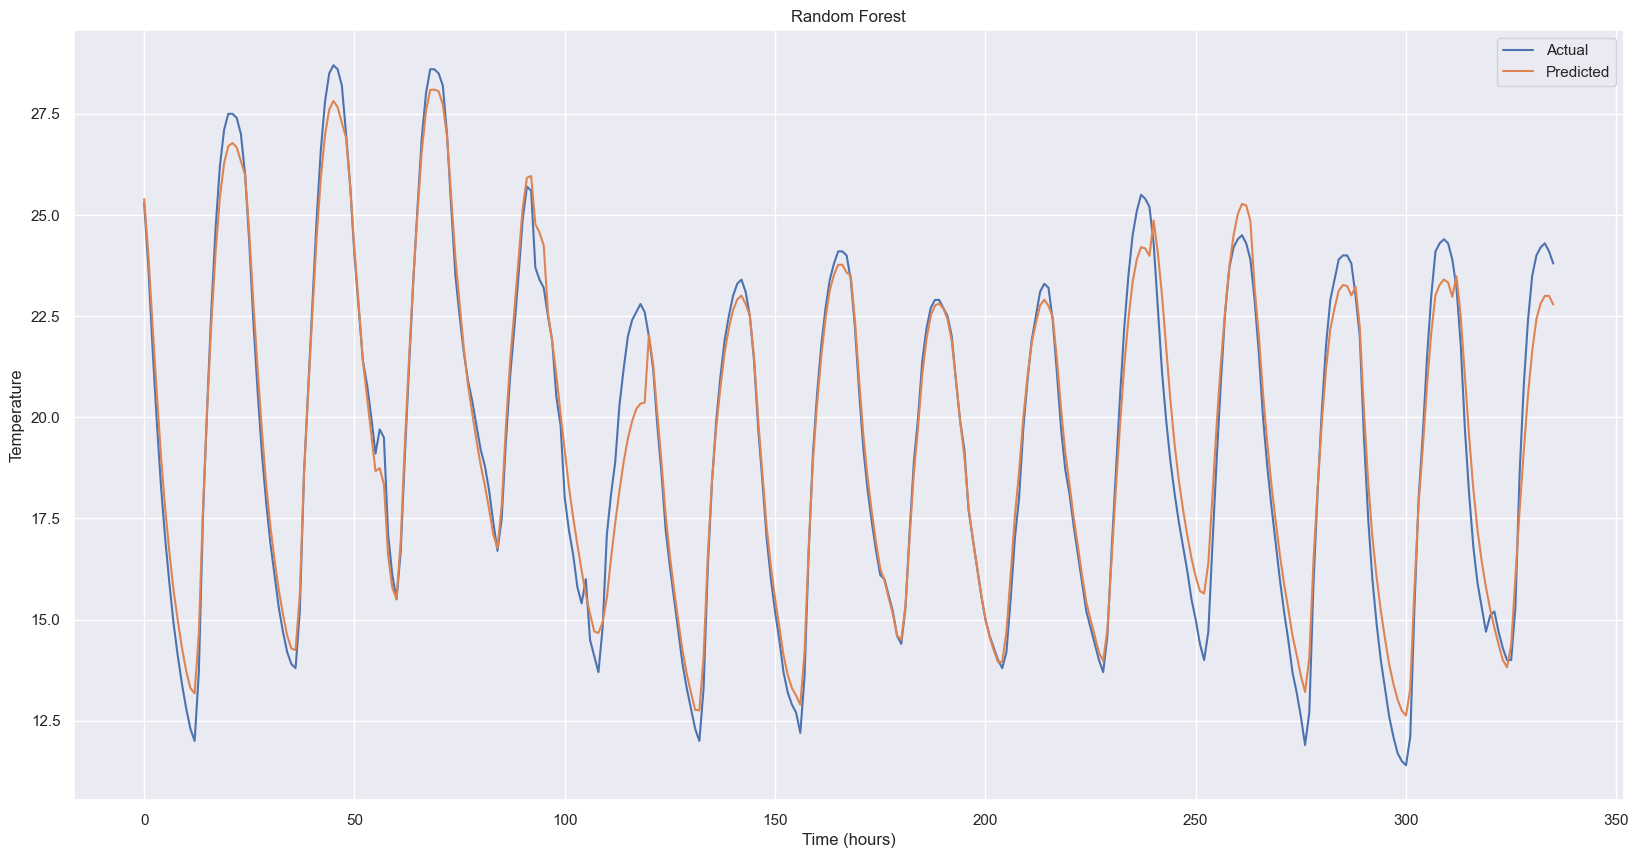

In [179]:
draw(random_forest_model, 'Random Forest', test_amount=14, columns=weather.columns)

In [84]:
pickle.dump(random_forest_model, open('./models/random_forest', 'wb'))

In [ ]:
rft = pickle.load(open('~/models/random_forest', 'rb'))

### XGBoost

In [72]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)

dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)

params = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}
num_rounds = 100
xgboost_model = xgb.train(params, dtrain, num_rounds)

score(xgboost_model, dtest, y_test)

MSE: 5.428634696514244
MAE: 1.6848553811753828
R2: 0.9566128604664815


In [78]:
xgboost_model.save_model('./models/xgboost.json')

### Trained XGBoost

In [79]:
booster = xgb.Booster()
booster.load_model('./models/xgboost.json')

In [188]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24, shuffle=False)

dtest = xgb.DMatrix(X_test, label=y_test.values)

score(booster, dtest, y_test)

MSE: 5.164640162836334
MAE: 1.6480081600137977
R2: 0.9536484292642756


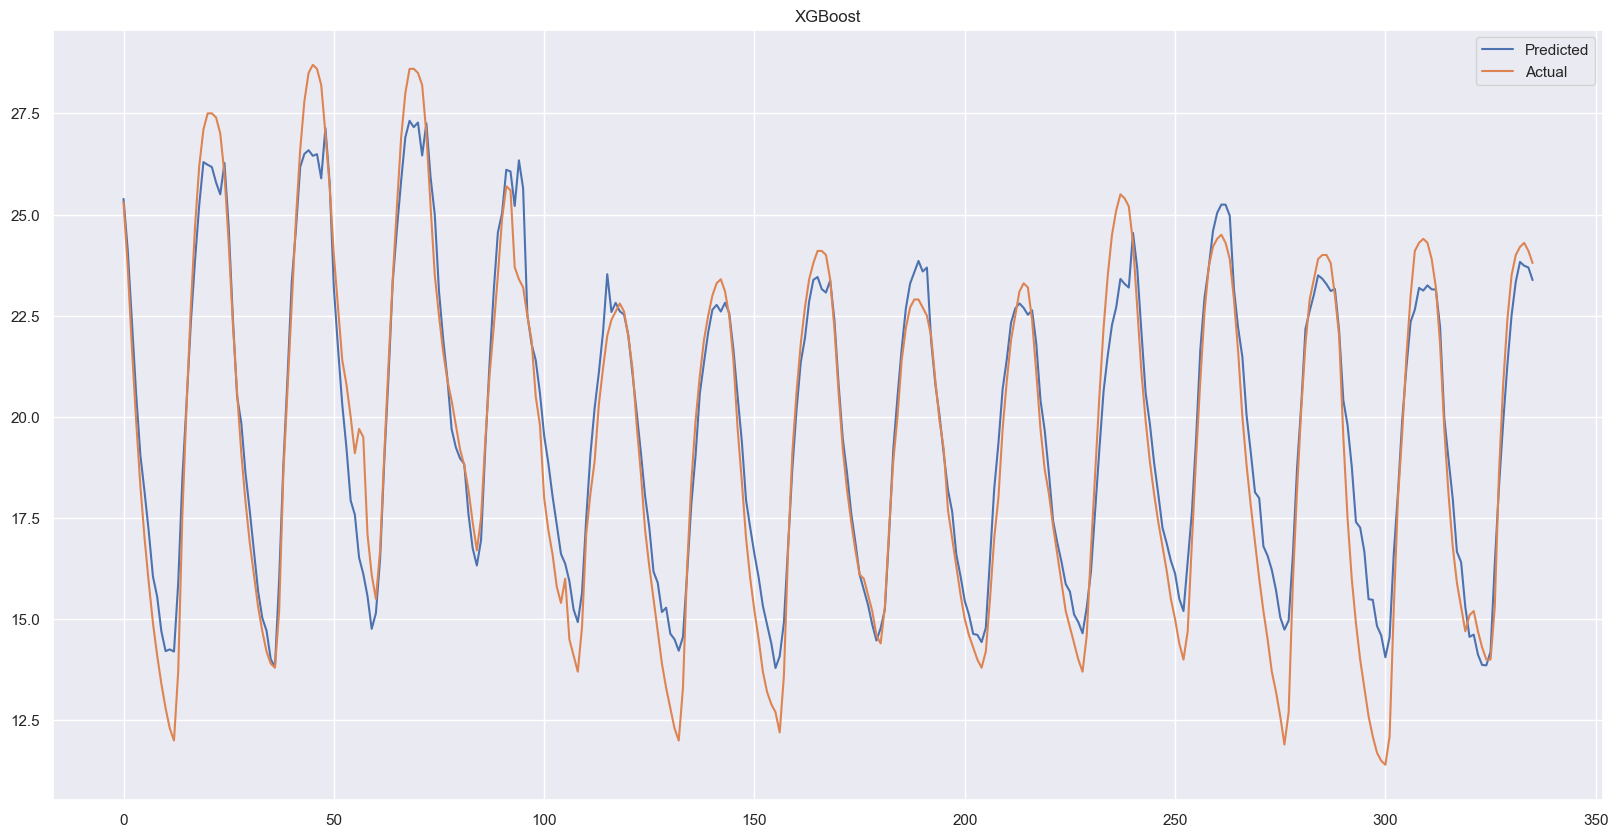

In [189]:
y_pred = booster.predict(dtest)[::24]
y_test = y_test[::24]

plt.plot(y_pred[:14].reshape(1, -1)[0], label='Predicted')
plt.plot(y_test.values[:14].reshape(1, -1)[0], label='Actual')
plt.title('XGBoost')
plt.legend()
plt.show()

### Neural Networks

In [57]:
def draw_nn(model, title, test_amount: int = 7, window_size: int = 168, columns: list[str] = ['temperature'], predict_duration: int = 24):
     weather = load_dataset(columns=columns)

     _, X_test, _, y_test = get_train_test(weather, window_size, predict_duration, shuffle=False)
     scaler = MinMaxScaler()
     X_test_scaled = scaler.fit_transform(X_test)
     X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

     X_test_tensor = X_test_tensor[::predict_duration]
     y_test = y_test[::predict_duration]

     y_pred = model(X_test_tensor)
     if type(y_pred) == tuple:
          y_pred = y_pred[0]
          
     y_test_pred = y_pred.detach().numpy()[:test_amount].reshape(1, -1)[0]
     y_test_actual = y_test.values[:test_amount].reshape(1, -1)[0]

     # Plot the predicted vs. actual temperatures
     sns.set(rc={'figure.figsize': (20, 10)})
     plt.plot(y_test_actual, label='Actual')
     plt.plot(y_test_pred, label='Predicted')
     plt.title(title)
     plt.xlabel('Time (hours)')
     plt.ylabel('Temperature')
     plt.legend()
     plt.show()

### Multilayer Perceptron (MLP)

In [106]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_dim = X_train.shape[1]
hidden_dim = 168
output_dim = y_train.shape[1]

mlp_model = MLP(input_dim, hidden_dim, output_dim)

criterion = nn.L1Loss()
optimizer = optim.Adagrad(mlp_model.parameters(), lr=0.01)

num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    y_pred = mlp_model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        y_pred = mlp_model(X_test_tensor)
        mse = criterion(y_pred, y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse:.4f}')


with torch.no_grad():
    y_pred = mlp_model(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

Epoch [100/5000], MSE: 7.2217
Epoch [200/5000], MSE: 6.7516


KeyboardInterrupt: 

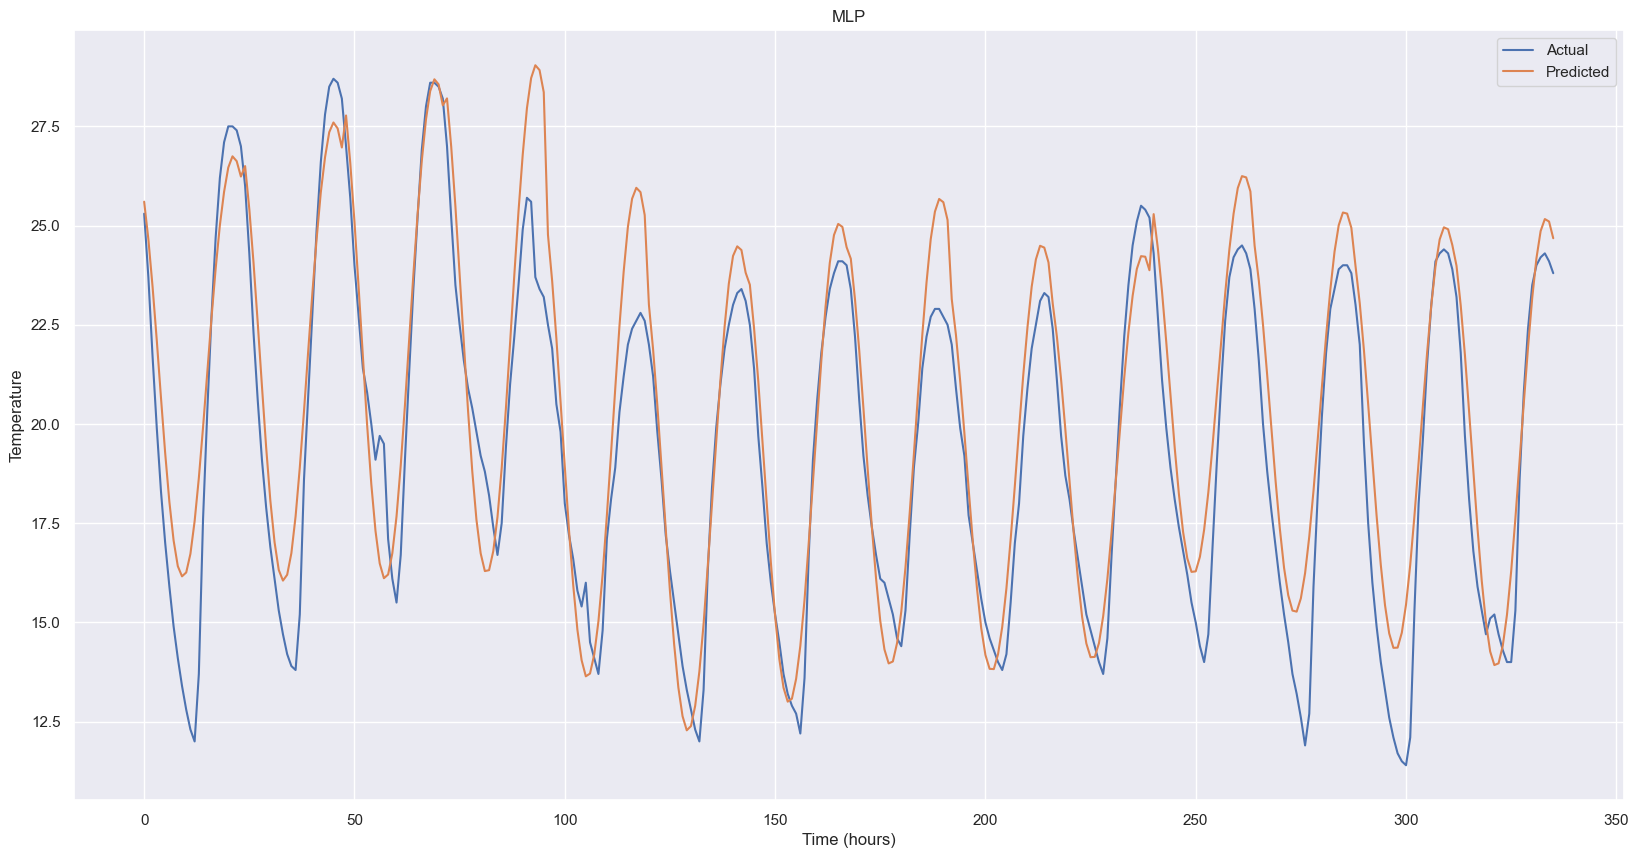

In [89]:
draw_nn(mlp_model, 'MLP', test_amount=14, window_size=168, columns=weather.columns)

In [90]:
torch.save(mlp_model.state_dict(), './models/mlp_h168_10k.json')

### Trained MLP

MSE: 1.9548
MAE: 1.9547739
R2: 0.9389372049916349


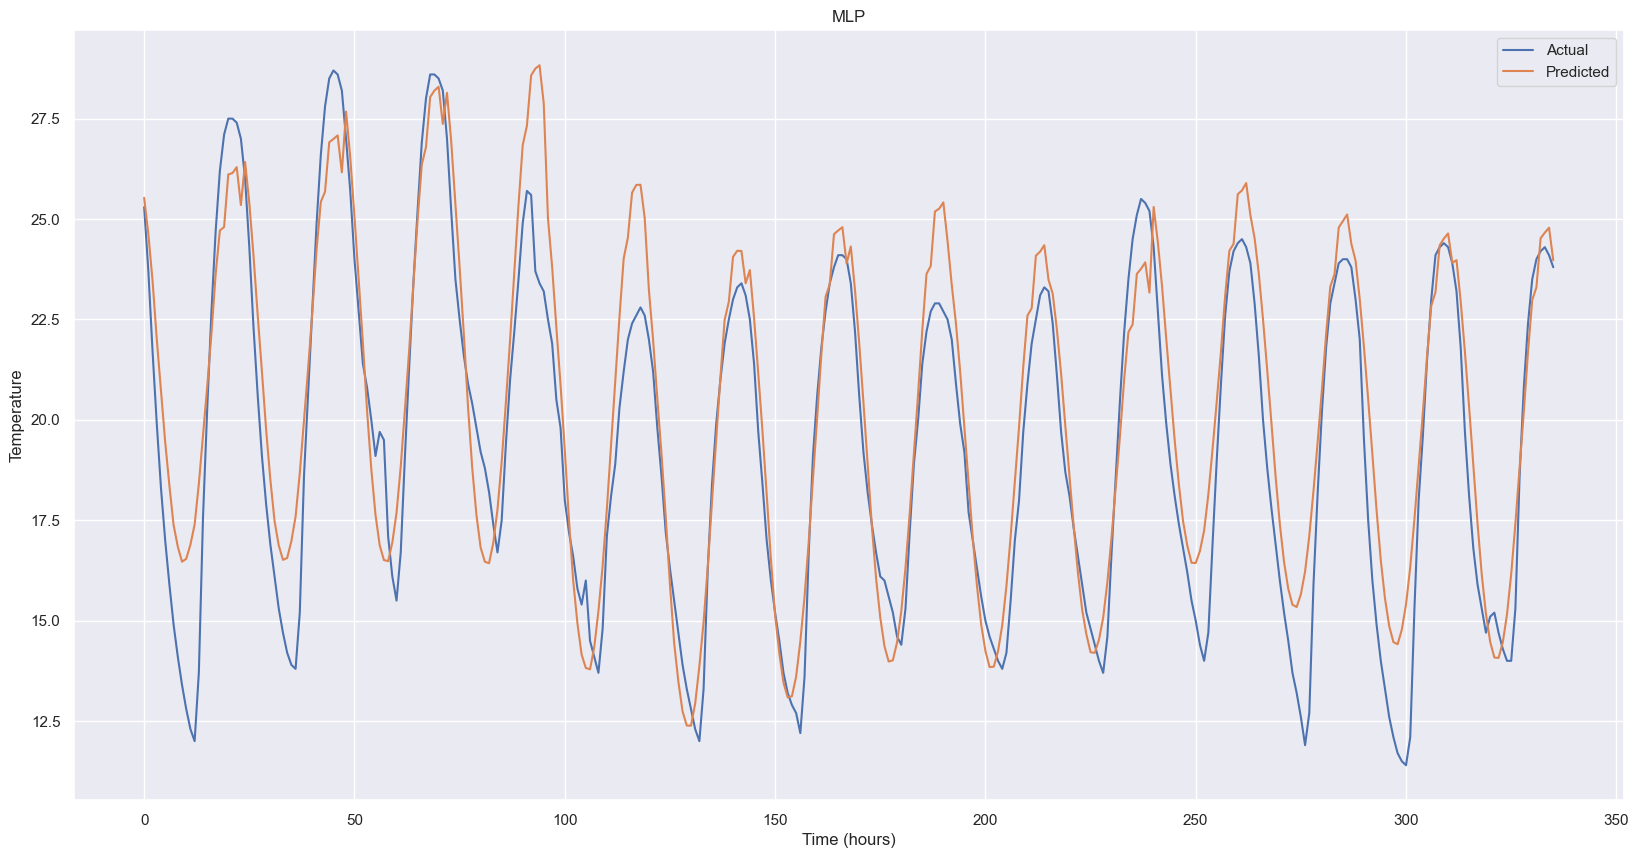

In [181]:
mlp2 = MLP(168, 24, 24)
mlp2.load_state_dict(torch.load('./models/mlp_h24_10k.json'))
with torch.no_grad():
    y_pred = mlp2(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

    
draw_nn(mlp2, 'MLP', test_amount=14, columns=weather.columns)

### MLP Architectures comparing

In [147]:
result = []
stats = []
hidden_sizes = [6, 12, 24, 48, 96, 168]
num_epochs = 1000

for hidden_size in hidden_sizes:
    mlp = MLP(168, hidden_size, 24)

    criterion = nn.L1Loss()
    optimizer = optim.Adagrad(mlp.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        y_pred = mlp(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)

        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            with torch.no_grad():
                y_pred = mlp(X_test_tensor)
                mse = criterion(y_pred, y_test_tensor)
                stats.append({
                    'hidden_size': hidden_size,
                    'iteration': epoch+1,
                    'mse': mse.item(),
                    'mae': mean_absolute_error(y_pred, y_test_tensor),
                    'r2': r2_score(y_pred, y_test_tensor),
                })

    with torch.no_grad():
        y_pred = mlp(X_test_tensor)
        mse = criterion(y_pred, y_test_tensor)
        result.append({
            'hidden_size': hidden_size,
            'mse': mse.item(),
            'mae': mean_absolute_error(y_pred, y_test_tensor),
            'r2': r2_score(y_pred, y_test_tensor),
        })

In [148]:
result_df = pd.DataFrame(result)
result_df

,hidden_size,mse,mae,r2
0,6,7.139287,7.139287,-6.631371
1,12,6.630356,6.630352,-2.547371
2,24,5.954886,5.954884,-0.728848
3,48,5.778455,5.778454,-0.554940
4,96,4.242085,4.242084,0.472470
5,168,3.290027,3.290025,0.741152


In [165]:
stats_df = pd.DataFrame(stats)
stats_df['r2'] = stats_df['r2'].apply(lambda x: 0 if x < -15 else x)
stats_df.head()

,hidden_size,iteration,mse,mae,r2
0,6,100,8.465412,8.465411,0.000000
1,6,200,7.957262,7.957266,0.000000
2,6,300,7.700408,7.700410,0.000000
3,6,400,7.557237,7.557228,0.000000
4,6,500,7.465621,7.465624,-11.712642


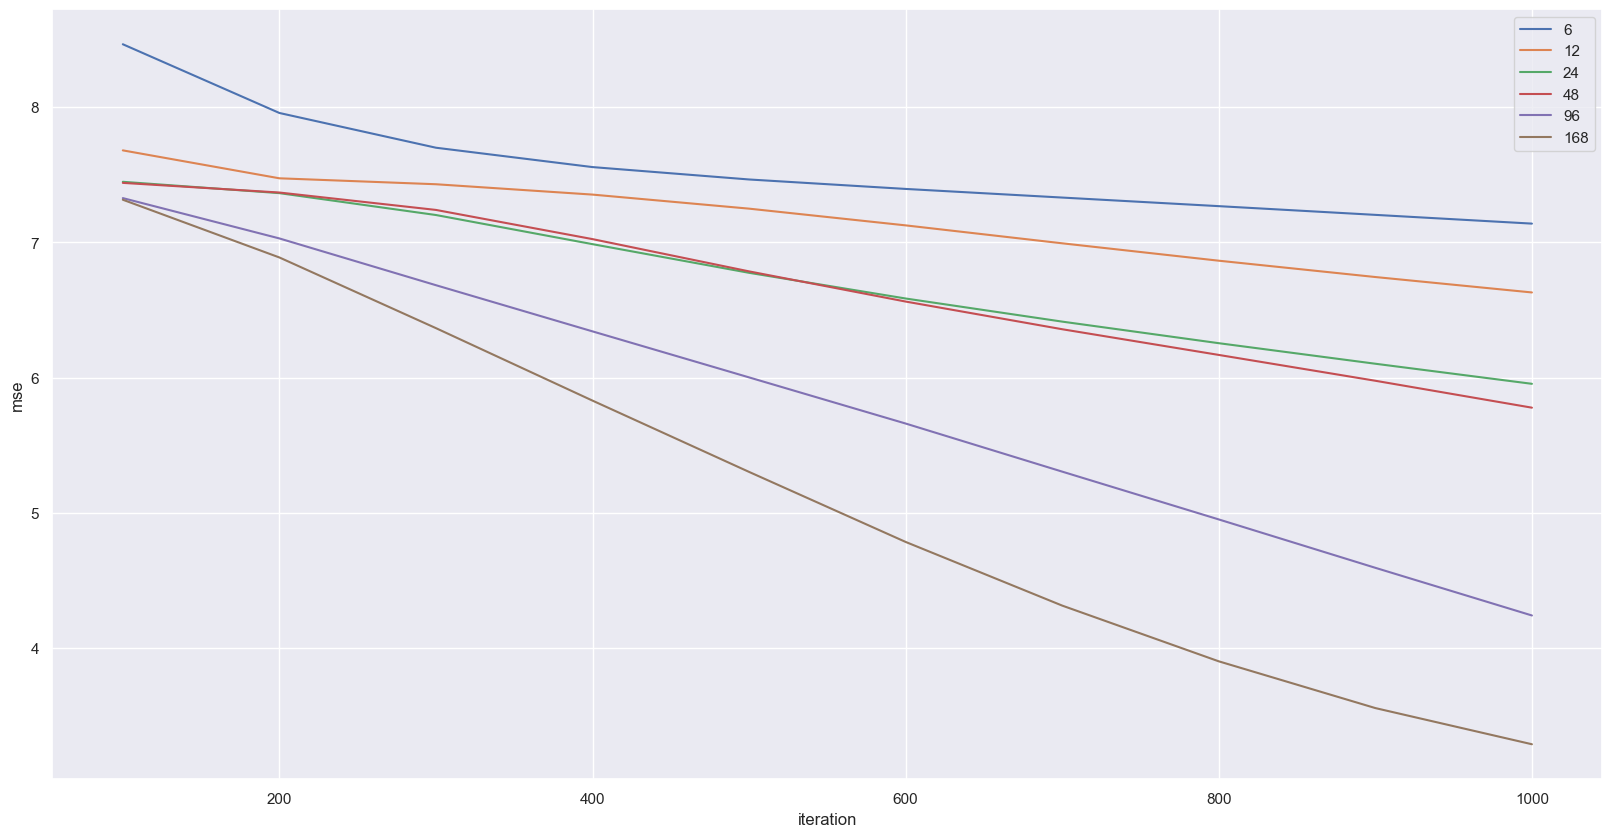

In [166]:
for key, df in stats_df.groupby('hidden_size'):
    plt.plot(df['iteration'], df['mse'], label=key)

plt.xlabel('iteration')
plt.ylabel('mse')
plt.legend()
plt.show()

### RNN

In [113]:
weather = load_dataset(limit=1000, columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)


class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden = None):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    
input_dim = X_train.shape[1]
hidden_dim = 12
output_dim = y_train.shape[1]

rnn = RNN(input_dim, hidden_dim, output_dim)

criterion = nn.L1Loss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

num_epochs = 1000
hidden = None  # initialize hidden state to None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred, hidden = rnn(X_train_tensor, hidden)

    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        y_pred, _ = rnn(X_test_tensor, hidden)  # use the same hidden state for prediction
        mse = criterion(y_pred, y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse:.4f}')

    # update hidden state for next epoch
    hidden = hidden.detach()


with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))


Epoch [100/1000], MSE: 4.9344
Epoch [200/1000], MSE: 4.1826
Epoch [300/1000], MSE: 3.7657
Epoch [400/1000], MSE: 3.5631
Epoch [500/1000], MSE: 3.4363
Epoch [600/1000], MSE: 3.2971
Epoch [700/1000], MSE: 3.1340
Epoch [800/1000], MSE: 2.7943
Epoch [900/1000], MSE: 2.3643
Epoch [1000/1000], MSE: 1.9766
MSE: 1.9766
MAE: 1.9766041
R2: 0.7828506159258297


In [114]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 168, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

MSE: 14.9084
MAE: 14.908357
R2: -10.742469043477394


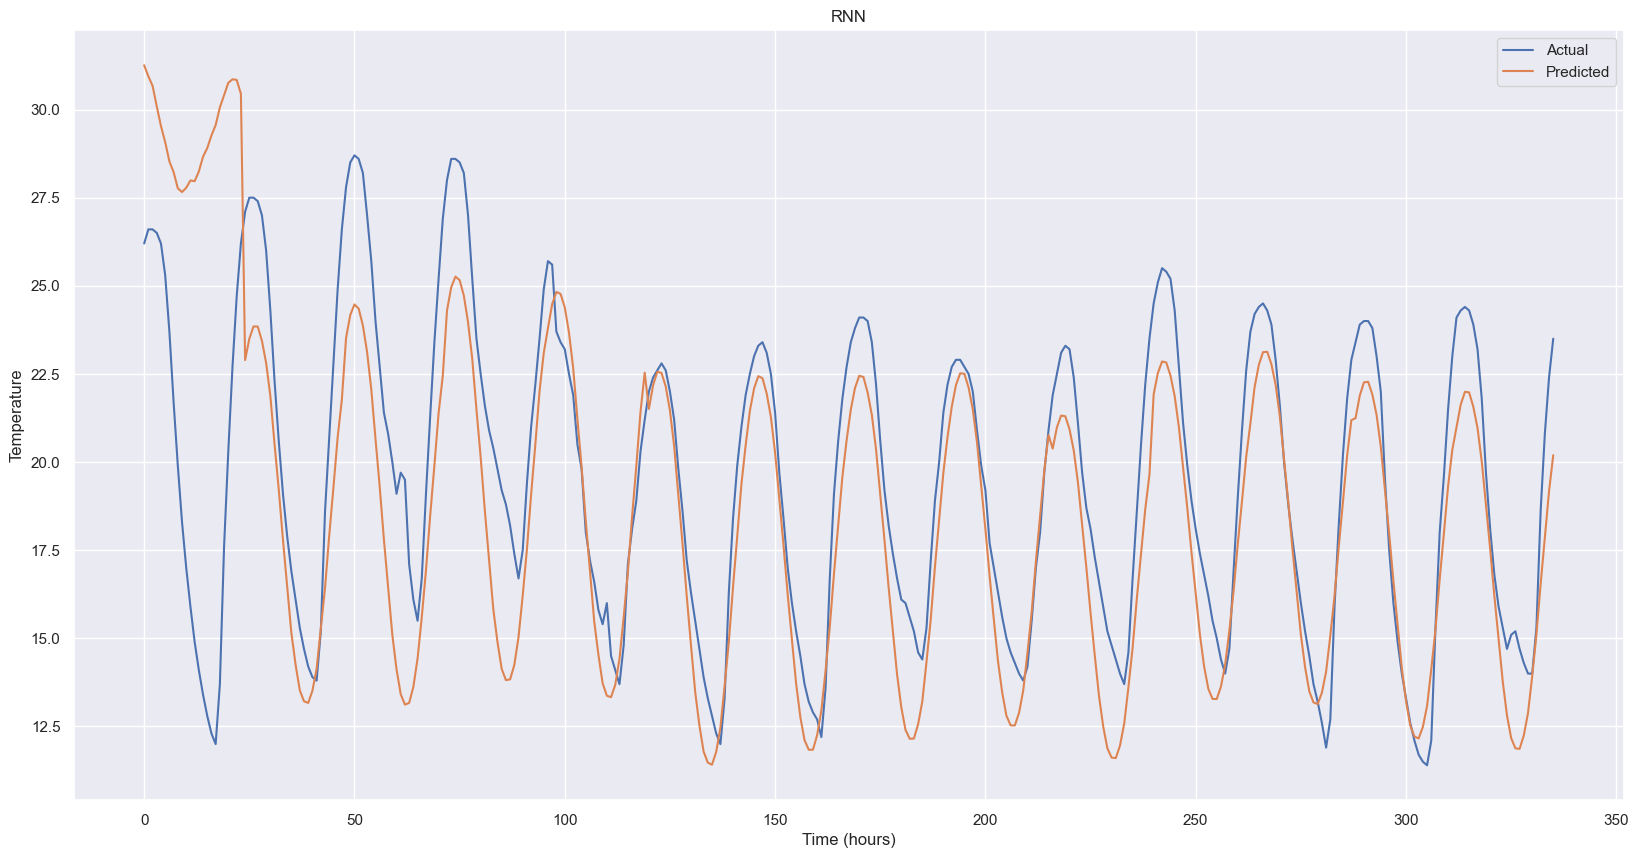

In [51]:
draw_nn(rnn, 'RNN', test_amount=14, columns=weather.columns)

In [49]:
torch.save(rnn.state_dict(), './models/rnn_h24_1k_50kstr.json')

In [31]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

MSE: 10.1530
MAE: 10.153018
R2: -101543.30201279193


### Trained RNN

In [62]:
rnn2 = RNN(144, 24, 24)
rnn2.load_state_dict(torch.load('./models/rnn_h24_1k_50kstr.json'))
with torch.no_grad():
    y_pred, _ = rnn2(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

    
draw_nn(rnn2, 'MLP', test_amount=14, columns=weather.columns)

NameError: name 'RNN' is not defined